# Babcock Machine Learning Test Exercise

### Approach & Methodology

- Understand the brief & aims
- Prepare, upload, view and sample the data (with some basic summaries)
- Data Cleansing
- Quick Exploratory analysis
- Feature Engineering & Sampling
- Model Build & consideration of approaches
- Validate model(s) & Performance Measurement
- Final solution & model interpretation
- Summarise findings

#### Brief & Aims

The task asks for a model to accurately classify articles into genre.  A standard data science scientific approach will be used, steps detailed above. 
A key aim will be to reach a workable solution and identify areas for later improvment. As time permits, improvments with the greatest estimated positive impact in the shortest time will be iteratively tackled. 

Potential uses is not detailed in the brief, but some consideration of real-world appication is essential for qualitative and quantitiative demands on the approach and accuracy.  For example, classification of articles for a hypothetical news aggregator site would demand a high level of classification accuracy, and a close analysis of misclassifications. However, observing or surveying trends over time of news article categorical bias, a lower accuracy might be permissible. 


Because this is an academic (test) exercise rather than a real-world application, aims will be to: 
- Show the scientific method & approach to solving this problem
- Illustrate some technical methods, ML model builds, and a few relevant cool things in python
- Build a working model and iterate to make some improvements
- Consider relative merits of some different approaches with respect to different potential real-world applictions

### Prepare, Upload, View, Sample
Files supplied in csv format with headers (test.csv, train.csv)    Fields: Class Index, Title, Description

In [93]:
# libraries needed
import numpy as np
import pandas as pd
# natural language toolkit
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
# visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle

In [94]:
#To replicate methods, may need to pip install some packages
#pip install wordcloud

In [95]:
#pip install altair

In [96]:
#pip install ipython-sql

In [97]:
# Read in and view top & bottom of training and test (validation) files
dftrain = pd.read_csv("/Users/colm/Desktop/train.csv")
# Sample for quick initial development
dftrain = dftrain.sample(10000)
# info will show top & tail records and table structure
dftrain.info

<bound method DataFrame.info of        Class Index                                            Title  \
42616            3        Delta to Cut Execs, Workers Pay by 10 Pct   
10964            2       Bertuzzi Pleads Not Guilty to Assault (AP)   
39478            1          Four terror suspects arrested in London   
85946            4              Irish urged to reduce gas emissions   
65870            3           Bank sages stumped by economic riddles   
...            ...                                              ...   
13446            1           Chechnya to hold presidential election   
65437            4        Windows XP Service Pack 2: Is It Time Yet   
66207            4  Cingular Operating Profits Dip, Revenue Up (AP)   
60982            1                 Gbagbo calls on rebels to disarm   
55883            2                          Bunch of TDs from Brady   

                                             Description  
42616   CHICAGO (Reuters) - Delta Air Lines &lt;A HRE...

In [98]:
dfvalidate = pd.read_csv("/Users/colm/Desktop/test.csv")
dfvalidate.info

<bound method DataFrame.info of       Class Index                                              Title  \
0               3                  Fears for T N pension after talks   
1               4  The Race is On: Second Private Team Sets Launc...   
2               4      Ky. Company Wins Grant to Study Peptides (AP)   
3               4      Prediction Unit Helps Forecast Wildfires (AP)   
4               4        Calif. Aims to Limit Farm-Related Smog (AP)   
...           ...                                                ...   
7595            1                                   Around the world   
7596            2                        Void is filled with Clement   
7597            2                             Martinez leaves bitter   
7598            3  5 of arthritis patients in Singapore take Bext...   
7599            3                             EBay gets into rentals   

                                            Description  
0     Unions representing workers at Turner  

Quick Observations
120,000 to train with, 7,600 to validate. 
Probably will not need to use test records in final model, but could do for best practice. 
Broadly the classes are intuitively as described in the brief:

(1) World
(2) Sport
(3) Business
(4) Science_Tech

What we want is high correct classification rate on test (validation) set.  
We might want to look at misclassifications (false positives & false negatives) to understand any systematic classification failures and whether the model would be fit for real world purpose.

In [99]:
# rows & columns
dftrain.shape

(10000, 3)

In [100]:
dfvalidate.shape

(7600, 3)

## Some Basic Data Cleansing
- The data is already very well prepared, no nulls to worry about. Index is already numeric (label coded)  
With more time, could do:
- Special character cleaning. Upcase / downcase. Punctuation. Signs. Remove HTML or other code

I will add a length column on for the descriptions to see how that is distributed
    

Sensible column names without spaces (changed first column to remove space)  

In [101]:
for df in [dftrain, dfvalidate]:
    df.columns = ['class_index', 'title', 'description']
    df.dropna()
# looking for null values, pretty much clear
#dftrain.apply(pd.Series.value_counts)
#print(dftrain)
print(dfvalidate)

      class_index                                              title  \
0               3                  Fears for T N pension after talks   
1               4  The Race is On: Second Private Team Sets Launc...   
2               4      Ky. Company Wins Grant to Study Peptides (AP)   
3               4      Prediction Unit Helps Forecast Wildfires (AP)   
4               4        Calif. Aims to Limit Farm-Related Smog (AP)   
...           ...                                                ...   
7595            1                                   Around the world   
7596            2                        Void is filled with Clement   
7597            2                             Martinez leaves bitter   
7598            3  5 of arthritis patients in Singapore take Bext...   
7599            3                             EBay gets into rentals   

                                            description  
0     Unions representing workers at Turner   Newall...  
1     SPACE.com - T

In [136]:
#decode genre for readability and outputs
genre = {
    1 : 'World',
    2 : 'Sport',
    3 : 'Business',
    4 : 'Science_Tech'
}
for df in [dftrain, dfvalidate]:
    #ganre decode
    dftrain['genre'] = dftrain['class_index']
    dftrain = dftrain.replace({'genre':genre})
# print(dftrain)

In [103]:
x = dftrain.class_index
x.value_counts()

2    2579
4    2574
1    2498
3    2349
Name: class_index, dtype: int64

In [104]:
x = dfvalidate.class_index
x.value_counts()

3    1900
2    1900
1    1900
4    1900
Name: class_index, dtype: int64

## Exploratory Data Analysis
- Record frequencies within categories
- Consider balance for under/over sampling
- Description lengths
- Word clouds to get a sense of content  
Feature engineering will be considered separately

Text(0.5, 1.0, 'Category frequencies in training set')

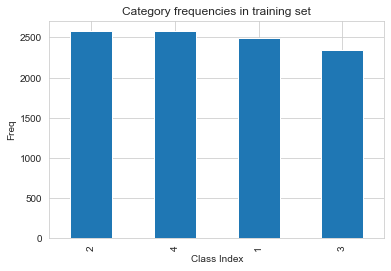

In [105]:
dftrain['class_index'].value_counts().plot(kind='bar')
plt.xlabel("Class Index")
plt.ylabel("Freq")
plt.title("Category frequencies in training set")

There is an evenly split distribution of class index, it is perfectly balanced so no under/oversampling needed  
Double checked in Excel pivot as too exact, obviously constructed that way already

Text(0.5, 1.0, 'Category frequencies in test (validation) set')

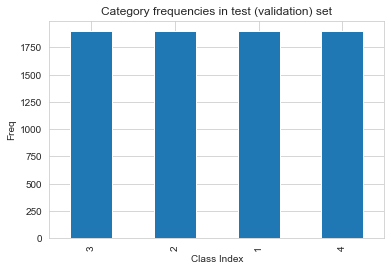

In [106]:
dfvalidate['class_index'].value_counts().plot(kind='bar')
plt.xlabel("Class Index")
plt.ylabel("Freq")
plt.title("Category frequencies in test (validation) set")

In [107]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Some world clouds just to get a sense of the article classes and whether the brief's descriptions are appropriate

There are 111972 words in the chosen title field


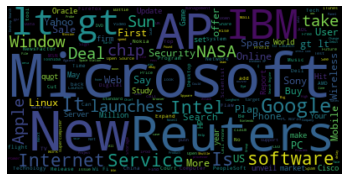

In [108]:
# put all words together for a given class
text = " ".join(t for t in dftrain[dftrain.class_index == 4].title.tolist())
print ("There are {} words in the chosen title field".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [109]:
#add a description length field
dftrain['description_length'] = dftrain['description'].str.len()
print(dftrain)

       class_index                                            title  \
42616            3        Delta to Cut Execs, Workers Pay by 10 Pct   
10964            2       Bertuzzi Pleads Not Guilty to Assault (AP)   
39478            1          Four terror suspects arrested in London   
85946            4              Irish urged to reduce gas emissions   
65870            3           Bank sages stumped by economic riddles   
...            ...                                              ...   
13446            1           Chechnya to hold presidential election   
65437            4        Windows XP Service Pack 2: Is It Time Yet   
66207            4  Cingular Operating Profits Dip, Revenue Up (AP)   
60982            1                 Gbagbo calls on rebels to disarm   
55883            2                          Bunch of TDs from Brady   

                                             description         genre  \
42616   CHICAGO (Reuters) - Delta Air Lines &lt;A HRE...      Business   

In [110]:
print(dftrain)

       class_index                                            title  \
42616            3        Delta to Cut Execs, Workers Pay by 10 Pct   
10964            2       Bertuzzi Pleads Not Guilty to Assault (AP)   
39478            1          Four terror suspects arrested in London   
85946            4              Irish urged to reduce gas emissions   
65870            3           Bank sages stumped by economic riddles   
...            ...                                              ...   
13446            1           Chechnya to hold presidential election   
65437            4        Windows XP Service Pack 2: Is It Time Yet   
66207            4  Cingular Operating Profits Dip, Revenue Up (AP)   
60982            1                 Gbagbo calls on rebels to disarm   
55883            2                          Bunch of TDs from Brady   

                                             description         genre  \
42616   CHICAGO (Reuters) - Delta Air Lines &lt;A HRE...      Business   

Text(0.5, 1.0, 'Description length (characters)')

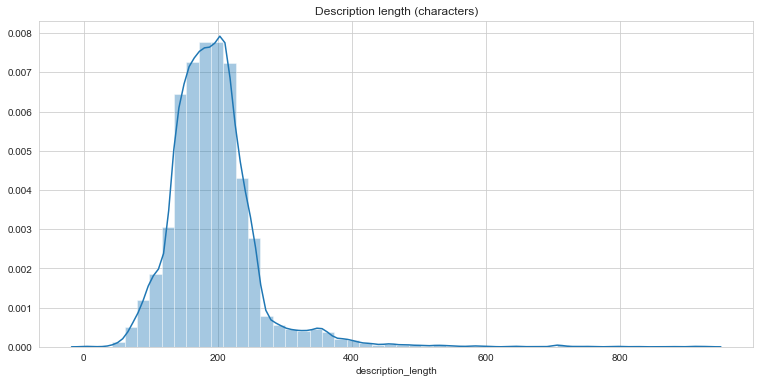

In [111]:
#plot the distribution of description length
plt.figure(figsize=(12.8,6))
sns.distplot(dftrain['description_length']).set_title('Description length (characters)')

OK, so around 200 characters, with very few anomolies (low or high)

## Feature Extraction / Feature Engineering
This can be quite time intensive, so for the purpose of this exercise I will keep it minimal but offer suggestions for extension. 
- TF-IDF vectors (relative importance of terms)
- Word Count Vectors (or other Bag of Words methods)
- Stemming or lematization (reduction to root & meaning)
- Stop words (like 'the' or 'what') that are unlikely to have predictive power
- Other manual creation of features (I've added only character length)

I'll use TF-IDF Vectors as features to be used in the model(s)

In [112]:
#data are already organised into train and test, but need to split out target var
#X_train, X_test, Y_train, Y_test = train_test_split(dftrain['description'],
#                                                    dftrain['class_index'], 
#                                                    test_size=0.15,
#                                                    random_state=8)
X_train = dftrain['description']
y_train = dftrain['class_index']
X_test = dfvalidate['description']
y_test = dfvalidate['class_index']

In [113]:
# Parameters
# consider unigrams and bigrams
ngram_range = (1, 2)
# document frequency min and max
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8', 
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

# fit and transform the training set
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

# transform but do not fit the test set
features_test = tfidf.fit_transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)
                        

(10000, 300)
(7600, 300)


In [114]:
print(tfidf)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=300,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


With more time, could take a look at which unigrams and bigrams are most correlated with each category for interest, and also to show if it would be worth spending time creating more features or other data normalisation.

## Model Build

Supervised machine learning techniques are most appropriate here because we absolutely know the outcome we want to predict (the class index or category).  Deep learning algorithms may be considered later, but experience suggests concentrating on these for now will probably be the best option (we want simplicity and to avoid overfitting). 


### Types of (supervised) model for champion challenger comparison for this text classification model could include:
- Random Forest (preferred statistical method based on community success and simplicity)
- SVM (Support Vector Machine)
- K Nearest Neighbours
- Gradient Boosting, XG Boost
- Multinomial Logistic or standard discriminant analysis (more appropriate if we have more features already defined in the data)
- Naive Bayes
- Neural Nets or layered deep learning algorithms

I'll limit to SVM for now for the purpose of the exercise.  Some quick research from the python community shows that this method often comes out top in comparative performance tests. We will, however, determine if the performance we manage to get is fit for purpose.

The general method would be:
- Ensure datasets prepared with all features required for modelling
- Decide on hyperparameters tune (parameters vary according to the individual model types)
- Define performance metrics (% accuracy will be the main one, could use concordance or other measures)
- Random Search and Grid Search Cross Vaidate process to find the best parameters for a given model type
- I would always consider whether further feature engineering might be needed or beneficial

In [115]:
# In summary we have the following objects for modelling
# X_train ()
# y_train (target variable, class_index)
# features_train (features matrix)
# labels_train (target)
# +those 4 for testing
# +tfidf (The TF-IDF Vector model)

In [116]:
#check dimension of feature vectors
print(features_train.shape)
print(features_test.shape)

(10000, 300)
(7600, 300)


In [117]:
svc_0=svm.SVC(random_state=8)
print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


I'll tune: C, kernel, gamma, degree. But try one first  
Use Randomized Search Cross Validaion to find our best model fit, then grid search based on the results to refine

In [118]:
# C (penalty of the error term)
C = [.01]
#C = [.0001, .001, .01]

# gamma
gamma = [10]
#gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [4]
#degree = [1, 2, 3, 4, 5]

# kernel (poly is likely to be best)
kernel = ['poly']
#kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.01],
 'degree': [4],
 'gamma': [10],
 'kernel': ['poly'],
 'probability': [True]}


In [119]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

In [120]:
# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

/Users/colm/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=8, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.01], 'degree': [4],
                                        'gamma': [10], 'kernel': ['poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_state=8, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=1)

In [121]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.709


Ideally here I would do a grid search to refine the search for the best model

In [122]:
best_svc = random_search.best_estimator_

In [123]:
best_svc

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=10, kernel='poly',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

## Model Fit & Performance

In [124]:
# fit the model on the training data
best_svc.fit(features_train, labels_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=10, kernel='poly',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

In [125]:
# Get the predictions on the test data
svc_pred = best_svc.predict(features_test)

In [126]:
# Training Accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The training accuracy is: 
0.9993
The test accuracy is: 
0.45710526315789474


46% is a model, but not a great one.  25% would be the lowest model accuracy (random allocation or constant allocation would achieve that). 

In [130]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           1       0.65      0.32      0.43      1900
           2       0.39      0.82      0.53      1900
           3       0.56      0.23      0.33      1900
           4       0.47      0.45      0.46      1900

    accuracy                           0.46      7600
   macro avg       0.52      0.46      0.44      7600
weighted avg       0.52      0.46      0.44      7600



In [131]:
print(svc_pred)

[4 4 2 ... 2 2 2]


In [134]:
print(dftrain)

       class_index                                            title  \
42616            3        Delta to Cut Execs, Workers Pay by 10 Pct   
10964            2       Bertuzzi Pleads Not Guilty to Assault (AP)   
39478            1          Four terror suspects arrested in London   
85946            4              Irish urged to reduce gas emissions   
65870            3           Bank sages stumped by economic riddles   
...            ...                                              ...   
13446            1           Chechnya to hold presidential election   
65437            4        Windows XP Service Pack 2: Is It Time Yet   
66207            4  Cingular Operating Profits Dip, Revenue Up (AP)   
60982            1                 Gbagbo calls on rebels to disarm   
55883            2                          Bunch of TDs from Brady   

                                             description         genre  \
42616   CHICAGO (Reuters) - Delta Air Lines &lt;A HRE...      Business   

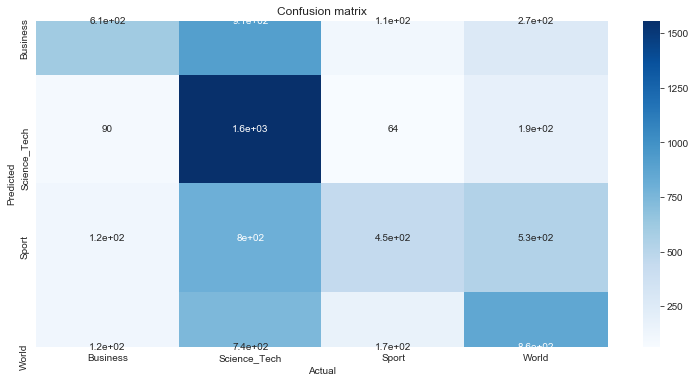

In [135]:
# Confusion matrix - (correct allocation matrix)
aux_df = dftrain[['genre']].drop_duplicates().sort_values('genre')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['genre'].values, 
            yticklabels=aux_df['genre'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Other measures of performance in addition to straignt accuracy would be:
- Accuracy & precision (precision being measure of positive patterns that are correctly predicted)
- Concordance (estimate of correctness using pairs of predictions). Especially logistic reg.
- Recall (fraction of positive patterns)
- F1, Gamme, TauA, each statistical method has its own set of metrics. 
- ROC or area under curve (cumulative %true positive versus %fals positive).  Great visually as and quite intuitive to explain)
- ROC (or Area Under Curve) charts are a favourite to show relative model performance

(lots of records will be misclassified due to subjective errors in the original classification, or where there really isn't enough information there to determine a good classification. Ideally check out misclassified records to see what the reasons might be, and assess whether these are acceptable

## Findings Summary

The method has resulted in a working model (initially 46% accuracy) and a workflow in Jupyter Notebooks and python to accomplish the task.  This is a good basis for future iterative model improvments and a number of imprtant techniques have been illustrated. 

This accuracy of the solution may be acceptable, depending on the real-world application (discussed ealier in the approach). There are however many ways to improve and fine tune the model, some of which will be possible in the time available. Notably:
- With greater performance available, use the whole dataset to train the model, not just a sample, and jot limited to the description texts. This is perhaps the greatest positive performance impact as we are training text models which benefit greatly from a greater corpus.  Evidenced also as I have shown improvements going from 1% through to 10% sampling.
- More advanced data cleansing including stop words & lemmatisation. 
- Feature engneering.  Especially if the real-world application is known this can qualitatively enhance the model as well. 
- Using different machine learning techniques (listed earlier), using similar performance measures. In particular Random Forest and neural nets. 
- Extended random search and grid searches. This can iteratively give good performance boost. 
- Other performance measures have been dentified to enhance understanding of the solution. 

### Next steps & Recommendations
- Time permitting, action some of the identified model improvments
- Discuss real-world application with the business / client to ensure fit for purpose
- Present solution(s) to both business stakeholder and technical audiences
- Collaborate with business to implement and productionise the model, and integrate with relevant systems & processes. 

### Contact
Colm O'Hanlon
colm.ohanlon@googlemail.com

### Appendices
Appendices and reference materials available on request only